# References:

Torchvision models: https://pytorch.org/vision/stable/models.html

VGG16 pre-trained: https://worksheets.codalab.org/worksheets/0xe2ac460eee7443438d5ab9f43824a819

How to freeze the layers:
https://androidkt.com/pytorch-freeze-layer-fixed-feature-extractor-transfer-learning/

https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch

https://debuggercafe.com/transfer-learning-with-pytorch/

Danni Chen\09/24/2021

In [1]:
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import sys

#torch
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim

# Import torch.nn which contains all functions necessary to define a convolutional neural network
import torch.nn as nn

# Import NiFTIDataset to access the train_test_split method and the NiFTIDataset class
from utils.loading.NiFTIDataset import train_test_split, NiFTIDataset
from utils.loading.NiFTIDataset import NiFTIDataset
from utils.transforms.torchvision import Repeat, Rescale, Unsqueeze

# Retrieve Dataset from Metadata Dataframe and Load with Dataloader

Number of data in the training dataset: 887
Number of data in the testing dataset: 223

{'image': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044,

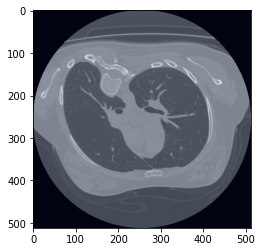

In [2]:
# MetaData dataframe
metadata = pd.read_csv("Metadata/metadata.csv")

# Construct the appropriate transforms needed in the neural net.
#
# Normalization follows guidelines in https://pytorch.org/vision/stable/models.html.
# Rescale the image to (0,1), then convert to 3-channel grayscale, then normalize
# it in accordance with how it should be done using the above link.
transform = transforms.Compose([
    Rescale(0,1),
    Unsqueeze(0),
    Repeat(3,1,1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

# Retrieve the dataset from info obtained in metadata dataframe
dataset = NiFTIDataset(metadata=metadata,root='.',transform=transform)

# Split a NiFTIDatset into two groups (training and testing) based on information specified within its metadata dataframe
# Return a tuple containing two NiFTIDataset objects with training and testing data, respectively.
(training_data,testing_data) = train_test_split(dataset)

print('Number of data in the training dataset: ' + str(len(training_data)))
print('Number of data in the testing dataset: ' + str(len(testing_data)) + '\n')

# Visualize the 886th image in the training dataset
t = training_data.__getitem__(886)
print(t)

# load the data with dataloader
train_dataloader = DataLoader(training_data,batch_size=64,shuffle=True)
test_dataloader = DataLoader(testing_data,batch_size=64,shuffle=False)

plt.imshow(Rescale(0,1)(t['image'].T))

# Initialize Pre-Trained VGG16, Freeze all Layers Except for FC Layer

In [3]:
# Initialize a pre-trained VGG16 object will download its weights to a cache directory.
vgg16 = models.vgg16(pretrained=True)

# print(vgg16.classifier[6].out_features) # 1000
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
# Freeze training for all layers
# To save computation time and that the network would already be able to extract generic features from the dataset.
for param in vgg16.features.parameters():
    param.requires_grad = False    

In [5]:
# https://androidkt.com/pytorch-freeze-layer-fixed-feature-extractor-transfer-learning/
# Remove the original fully-connected layer (the last layer) and create a new one
# Newly created modules have requires_grad=True by default
num_features = vgg16.classifier[6].in_features
classifier_layers = list(vgg16.classifier.children())[:-1] # Remove the last layer
classifier_layers.extend([nn.Linear(in_features = num_features, out_features= 2)]) # Add the new layer with outputting 2 categories
vgg16.classifier = nn.Sequential(*classifier_layers) # Replace the model classifier, Overwriting the original

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Set Loss Function and Optimizer

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss() 

# Optimizer, only the parameters of the classifier are optimized
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

# optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Model Training

In [7]:
# training
# train for 2 epochs
vgg16.train()

for epoch in range(2): 
    
    # initiate running_loss
    running_loss = 0.0 

    for ith_batch,batch_data in enumerate(train_dataloader): 
        # obtain the images and labels
        img_batch,labels_batch = batch_data['image'],batch_data['label']
        
#         print(img_batch.shape) #torch.Size([64, 3, 512, 512])
        
        # convert the shape of labels_batch from 64*4 to be 64*2         
        # change labels 2 and 3 to 1
        labels_batch[labels_batch != 0] = 1
#         print(labels_batch)
        
        # zero the parameter gradients (necessary because .backward() accumulate gradient for each parameter after each iteration)
        optimizer.zero_grad()

        # forward + backward + optimize
        # feed the img_batch (input) into the network
        outputs = vgg16(img_batch.float())
#         print(outputs)
#         print(outputs.shape) 
#         print(labels_batch.shape)
        
        # calculate the cross-entropy loss
        loss = criterion(outputs, labels_batch)
        # backward
        loss.backward()
        # perform parameter update based on current gradient (stored in .grad) and update rule of SGD
        optimizer.step()

        # print statistics
        running_loss += loss.item() # .item() extracts loss values as floats
        sys.stdout.write('\rRunning loss ({:d}/10): {:.3f}'.format((ith_batch % 10)+1, running_loss))
        
        # print every 10 mini-batches
        if ith_batch % 10 == 9:
            print('\nTen-batch statistics: [%d, %5d] loss: %.3f' %
                (epoch + 1, ith_batch + 1, running_loss / 10))
            running_loss = 0.0
        
        # print every 10 mini-batches
        # if ith_batch % 10 == 9:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, ith_batch + 1, running_loss / 10))
        #    running_loss = 0.0

print('\nFinished Training')

Running loss (10/10): 6.536
Ten-batch statistics: [1,    10] loss: 0.654
Running loss (10/10): 5.633
Ten-batch statistics: [2,    10] loss: 0.563
Running loss (4/10): 2.474
Finished Training


# Model Testing

In [8]:
# Testing

# Set the eval mode flag on the model (not important here but good practice)
vgg16.eval()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader: # iterate through the data
        images, labels = data['image'],data['label']
            
#         print(images.shape) #torch.Size([64, 3, 512, 512])
        
        labels[labels != 0] = 1
        
        # calculate outputs by running images through the network 
        outputs = vgg16(images.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        # increment total and correct
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
# print the accuracy
print('Accuracy of the networks: %d %%' % (
    100 * correct / total))

Accuracy of the networks: 77 %
